# Data preparation & Loading

In [180]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [181]:
# import dataset in csv format

df = pd.read_csv("EMCT_detail_correlated_2025_0610_pandas.csv")

In [182]:
# convert date to datetime object

df['date_filling'] = pd.to_datetime(df['date_filling'])
df['customer_recieve_date'] = pd.to_datetime(df['customer_recieve_date'])

In [183]:
# confirmation of Dtype change on date_filling and customer_recieve_date

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423 entries, 0 to 422
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   trailer_ID                    423 non-null    object        
 1   trailer_volumn                423 non-null    float64       
 2   pressure_prefill              423 non-null    int64         
 3   temperature_prefill           423 non-null    int64         
 4   date_filling                  423 non-null    datetime64[ns]
 5   pressure_postfill             423 non-null    int64         
 6   temperature_postfill          423 non-null    int64         
 7   volumn_filled                 423 non-null    int64         
 8   trailer_ID_2                  419 non-null    object        
 9   customer_name                 413 non-null    object        
 10  customer_recieve_date         413 non-null    datetime64[ns]
 11  time_gap                      41

# 1. Examine pressure distribution on (prefill & postfill)

Axes(0.125,0.11;0.775x0.77)


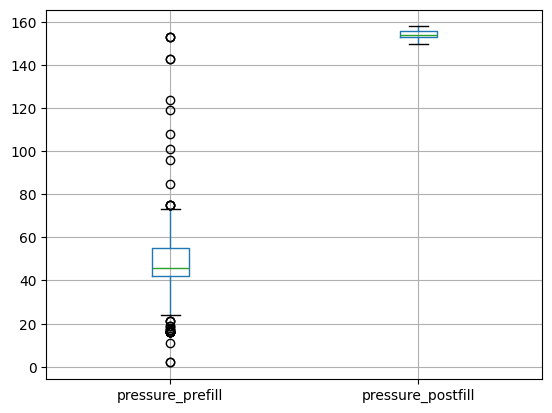

In [184]:
print(df.boxplot(column = ['pressure_prefill','pressure_postfill']))

This result correlate with the effective and controlled process that are applied by taking a variable initial pressure and reliably adjusts it to a consistent, high-pressure final state (method of filling by final pressure)




In [185]:
# examine normal prefill pressure

view1 = df[df['pressure_prefill'] < 80]
view1[['trailer_volumn','pressure_prefill','temperature_prefill']].head()

,trailer_volumn,pressure_prefill,temperature_prefill
0,9.11,30,24
1,9.12,27,14
2,9.11,26,20
3,9.12,35,15
4,9.11,30,15


In [186]:
# examine outliers

view2 = df[df['pressure_prefill'] > 140]
view2[['trailer_volumn','pressure_prefill','temperature_prefill']]

,trailer_volumn,pressure_prefill,temperature_prefill
13,17.71,143,25
20,18.21,153,22
21,18.37,153,20
25,19.14,153,26
413,17.71,143,25


# 2. Examine temperature distribution on (prefill & postfill)

Axes(0.125,0.11;0.775x0.77)


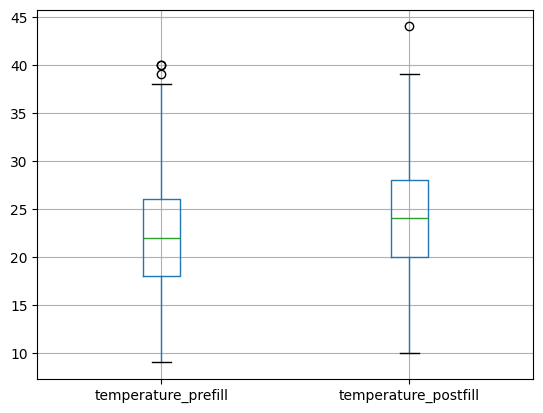

In [187]:
print(df.boxplot(column = ['temperature_prefill','temperature_postfill']))

the plot strongly implies that the filling process consistently raises the temperature, but it does not significantly change the overall variability of the temperature readings

In [188]:
# examine outliers

view3 = df[df['temperature_prefill'] > 35]
view3[['trailer_volumn','pressure_prefill','temperature_prefill']]

,trailer_volumn,pressure_prefill,temperature_prefill
24,18.37,44,36
111,17.71,56,36
166,18.37,43,38
170,18.21,46,39
240,18.37,46,36
246,18.37,44,36
302,18.37,49,36
304,18.37,45,40
384,18.37,26,40


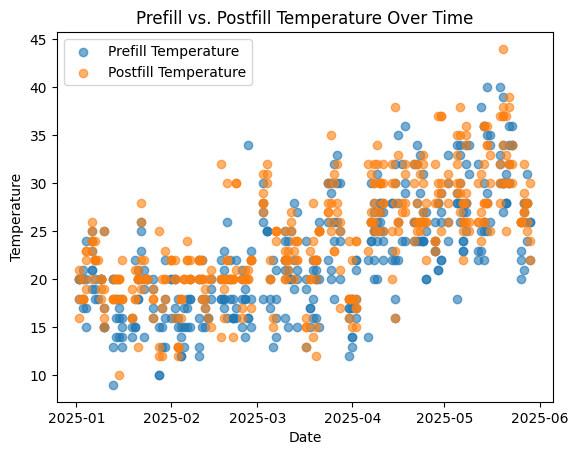

temperature prefill:
std: 22.425531914893618
mean 6.008959395942304

temperatiure postfill:
mean: 24.189125295508273
std 5.878483131303698


In [201]:
# examine temperature dependence on date
# make a scatter plot
plt.scatter(df['date_filling'], df['temperature_prefill'], alpha=0.6, label='Prefill Temperature') # alpha makes points slightly transparent
plt.scatter(df['date_filling'], df['temperature_postfill'], alpha=0.6, label='Postfill Temperature') # alpha makes points slightly transparent
plt.title('Prefill vs. Postfill Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# cauculate statistical parameters
print("temperature prefill:")
print("std:", df['temperature_prefill'].mean())
print("mean", df['temperature_prefill'].std())
print()
print("temperatiure postfill:")
print("mean:",df['temperature_postfill'].mean())
print("std",df['temperature_postfill'].std())

Clear Seasonal Trend: Both the temperature_prefill and temperature_postfill show a distinct upward trend from January 2025 to June 2025. This strongly suggests that the temperature is influenced by the time of year, with values being lower in the winter months and progressively increasing as it gets warmer towards the summer.

# Perform correlation mapping using heat map

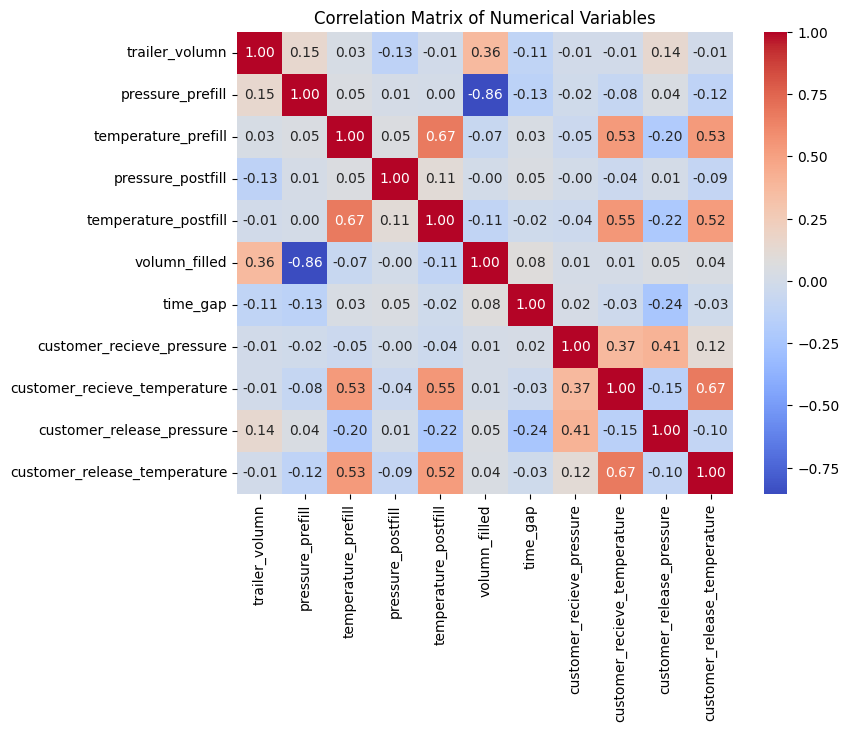

In [190]:
# Select only the numerical columns for correlation
numerical_df = df.select_dtypes(include=np.number)

# Calculate the correlation matrix
corr_matrix = numerical_df.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

1. This means that the higher the pressure in the trailer before filling, the less volume can be added. This makes perfect physical sense: a trailer that is returned with high residual pressure is already partially full, so less new product can be added.
2. This suggests that all temperature readings are heavily influenced by a common factor, which is almost certainly the ambient/seasonal temperature. When it's a hot day, all temperature measurements tend to be higher throughout the entire process.
3. In summary, the heatmap powerfully confirms that the starting pressure is the biggest driver of how much volume can be filled, and that all temperature measurements are linked by the outside weather conditions.

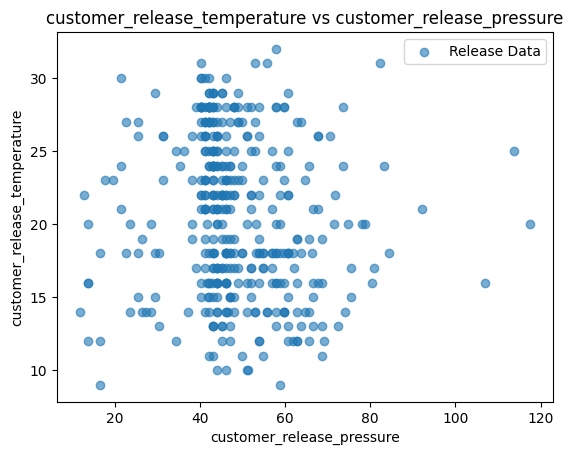

In [191]:
plt.scatter(df['customer_release_pressure'], df['customer_release_temperature'], alpha=0.6, label='Release Data') # alpha makes points slightly transparent
plt.title('customer_release_temperature vs customer_release_pressure')
plt.xlabel('customer_release_pressure')
plt.ylabel('customer_release_temperature')
plt.legend()
plt.show()

the figure shows the consistency with heatmap where little relationship is observed between customer_release_preesure and customer_release_temperatiure

# 3. Establish a predictive model on how much filled volume required based on the prefill pressure using ordinary least sqaured model (OLS)

step1. Prepare dataset

In [192]:
# use pressure_prefill to predict volumn_filled using OLS model

df_normal = df[(df['pressure_prefill'] < 80) & (df['volumn_filled'] > 1000)]
# setting the normal prefill pressure at 80barA (97.16% of all pressure_prefill measurements are lower than 80 barA)

ols_data = df_normal[['pressure_prefill', 'volumn_filled']]
# use two columns as subset for OLS prediction

ols_data.head()

,pressure_prefill,volumn_filled
11,2,2393
12,16,2279
14,17,2215
15,16,2177
16,70,1398


step2. import necessary library

In [193]:
# Import ols function
from statsmodels.formula.api import ols

step3. write the formula

In [194]:
ols_formula = "volumn_filled~pressure_prefill"
# using pressure_prefill to predict volume_filled

step4. Build OLS model, fit model to data

In [195]:
OLS = ols(formula = ols_formula, data = ols_data)
model = OLS.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          volumn_filled   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     4241.
Date:                Thu, 26 Jun 2025   Prob (F-statistic):          1.10e-214
Time:                        06:56:12   Log-Likelihood:                -2216.6
No. Observations:                 401   AIC:                             4437.
Df Residuals:                     399   BIC:                             4445.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2381.0095     12.042    197.719      0.000    2357.335    2404.684
pressure_prefill   -15.9016      0.244    -65.124      0.000     -16.382     -15.422
==============================================================================
Omnibus:                        0.232   Durbin-Watson:                   1.299
Prob(Omnibus):                  0.891   Jarque-Bera (JB):                0.126
Skew:                           0.036   Prob(JB):                        0.939
Kurtosis:                       3.050   Cond. No.                         195.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='pressure_prefill', ylabel='volumn_filled'>

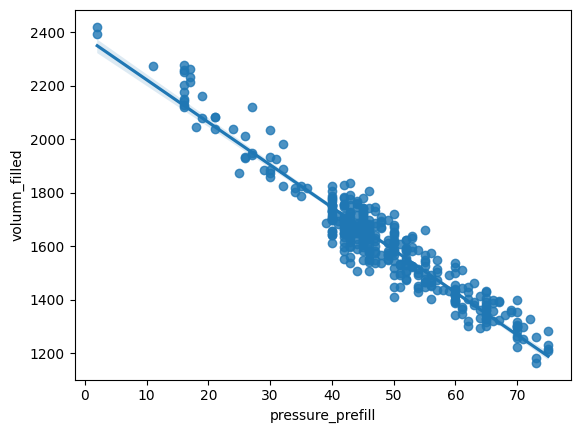

In [196]:
sns.regplot(x = "pressure_prefill", y = "volumn_filled", data = ols_data)
# make a scatter plot to visualize the model

Model Visualization: This plot visually confirms the strong negative linear relationship between pressure_prefill and volumn_filled. The data points are tightly clustered around the regression line, which aligns with the high R-squared value of 0.914 from the model summary. This provides a clear and intuitive understanding of the model's prediction: as pre-fill pressure increases, the fillable volume decreases in a predictable way.

"volumn_filled" = (-15.9016) * "pressure_prefill" + 2381.0095




step5. checking model assumptions:
"Linearity"
"Normality"
"Independent observations"
“Homoscedasticity”

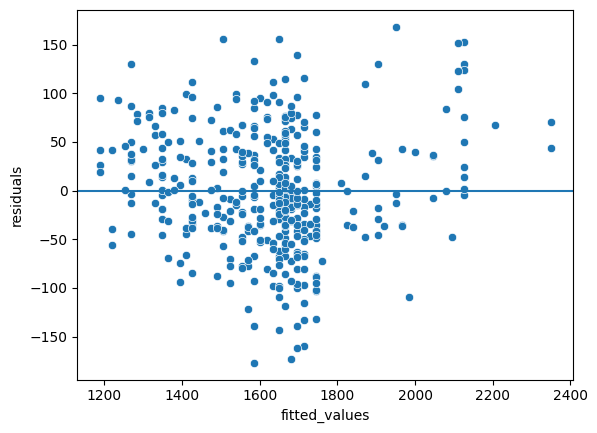

In [197]:
# make a scatter plot to see how residuals depends on x variable
x_subset = ols_data['pressure_prefill']

# Get predictions from model
fitted_values = model.predict(x_subset)

# cauculate residual values
residuals = model.resid

# make a scatterplot to visualize the distribution of residuals
fig = sns.scatterplot(x = fitted_values, y = residuals)
fig.set_xlabel("fitted_values")
fig.set_ylabel("residuals")
fig.axhline(0)
plt.show()

Linearity Assumption: The points appear to be randomly scattered around the horizontal line at residuals = 0. There are no discernible patterns, such as a U-shape, which indicates that the linear relationship assumed by our model is appropriate for this data

<Axes: >

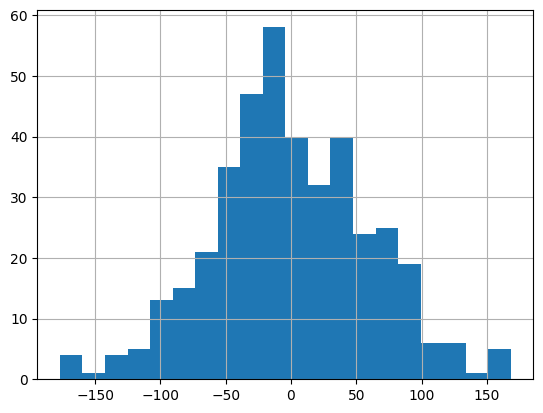

In [202]:
residuals.hist(bins = 20)

This histogram displays the distribution of the model's residuals. The shape is approximately bell-shaped and centered around 0, which visually supports the assumption that the errors are normally distributed.

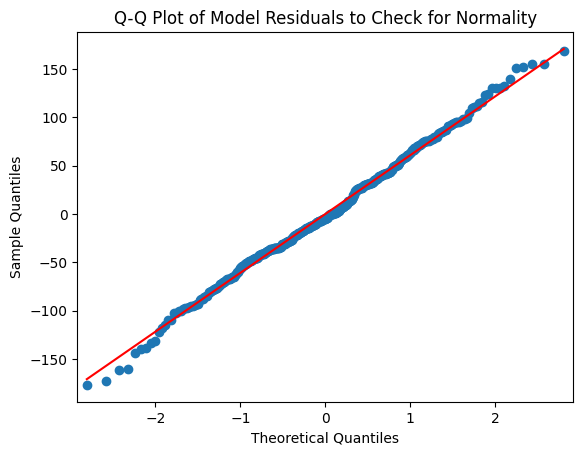

In [199]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig = sm.qqplot(model.resid, line = 's')
plt.title("Q-Q Plot of Model Residuals to Check for Normality")
plt.show()

The plot compares the quantiles of our model's residuals (Sample Quantiles) against the quantiles of a theoretical normal distribution. If the residuals are normally distributed, the data points (blue dots) will fall along the straight diagonal line (red line).